# Geospatial Store Optimization & Rationalization (with KMeans Clustering and Resource Reallocation)

Store Rationalization adalah reorganisasi perusahaan untuk meningkatkan efisiensi operasi dan mengurangi biaya. Akibat krisis Covid-19, beberapa bisnis retail dari seluruh dunia tutup toko. Itu bukan semata-mata gejala financial distress, bahkan banyak perusahaan yang memfokuskan investasinya untuk membuat bisnisnya lebih digital.

Kita akan menggunakan "set data Starbucks Stores" yang menyediakan lokasi semua toko yang beroperasi. Kita akan memilih area geografis tertentu dan, selain garis lintang dan garis bujur yang disediakan, kita akan mensimulasikan beberapa informasi bisnis untuk setiap toko dalam kumpulan data (biaya, kapasitas, staf).

Secara khusus, kita akan melalui:

- Setup: paket impor, membaca data geografis, membuat fitur bisnis.
- Analisis Data: penyajian kasus bisnis di peta dengan folium dan geopy.
- Clustering: Machine Learning (K-Means) dengan scikit-learn,
- Store Rationalization: membangun algoritma deterministik untuk menyelesaikan kasus bisnis.

In [1]:
## for data
import numpy as np
import pandas as pd

## for plotting
import matplotlib.pyplot as plt
import seaborn as sns

## for geospatial
import folium
import geopy

## for machine learning
from sklearn import preprocessing, cluster
import scipy

## menghindari memory leak
import os
os.environ["OMP_NUM_THREADS"] = "1"

In [2]:
dtf = pd.read_csv('https://raw.githubusercontent.com/mdipietro09/DataScience_ArtificialIntelligence_Utils/master/machine_learning/data_stores.csv')
dtf.columns.tolist()

['Brand',
 'Store Number',
 'Store Name',
 'Ownership Type',
 'Street Address',
 'City',
 'State/Province',
 'Country',
 'Postcode',
 'Phone Number',
 'Timezone',
 'Longitude',
 'Latitude']

In [3]:
dtf.nunique(axis=0)

Brand                 4
Store Number      25599
Store Name        25364
Ownership Type        4
Street Address    25353
City               5469
State/Province      338
Country              73
Postcode          18887
Phone Number      18559
Timezone            101
Longitude          6834
Latitude           3770
dtype: int64

Dataset asli berisi lebih dari 5,000 kota dan 25,000 toko, tetapi untuk tujuan study case ini, Kita akan bekerja hanya dengan satu kota yaitu Las Vegas.

In [4]:
LasVegas = "Las Vegas"
dtf = dtf[dtf["City"]==LasVegas][["City","Street Address","Longitude","Latitude"]].reset_index(drop=True)
dtf = dtf.reset_index().rename(columns={"index":"id"})
dtf.head()

,id,City,Street Address,Longitude,Latitude
0,0,Las Vegas,4507 Flamingo Rd,-115.20,36.12
1,1,Las Vegas,"475 E Windmill Lane, Fashion Show",-115.15,36.04
2,2,Las Vegas,"3200 LAS VEGAS BLVD. S., STE 1795",-115.17,36.13
3,3,Las Vegas,8350 W Cheyenne Ave,-115.28,36.22
4,4,Las Vegas,3730 LAS VEGAS BLVD S,-115.18,36.11


Di kawasan itu, ada 156 toko. Untuk melanjutkan kasus bisnis, kita akan mensimulasikan beberapa informasi untuk setiap toko:

- Potential: total kapasitas dalam hal staf (misalnya 10 berarti toko dapat memiliki hingga 10 karyawan)
- Staff: tingkat staf saat ini (misalnya 7 berarti toko saat ini beroperasi dengan 7 karyawan)
- Capacity: kapasitas kiri saat ini (misalnya 10–7=3, toko masih dapat menampung 3 karyawan)
- Cost: biaya tahunan bagi perusahaan untuk menjaga agar toko tetap beroperasi (“rendah”, “sedang”, “tinggi”)

In [5]:
dtf["Potential"] = np.random.randint(low=3, high=10+1, size=len(dtf))
dtf["Staff"] = dtf["Potential"].apply(lambda x: int(np.random.rand()*x)+1)
dtf["Capacity"] = dtf["Potential"] - dtf["Staff"]
dtf["Cost"] = np.random.choice(["high","medium","low"], size=len(dtf), p=[0.4,0.5,0.1])
dtf.head()


,id,City,Street Address,Longitude,Latitude,Potential,Staff,Capacity,Cost
0,0,Las Vegas,4507 Flamingo Rd,-115.20,36.12,7,5,2,medium
1,1,Las Vegas,"475 E Windmill Lane, Fashion Show",-115.15,36.04,10,6,4,high
2,2,Las Vegas,"3200 LAS VEGAS BLVD. S., STE 1795",-115.17,36.13,5,2,3,low
3,3,Las Vegas,8350 W Cheyenne Ave,-115.28,36.22,3,1,2,high
4,4,Las Vegas,3730 LAS VEGAS BLVD S,-115.18,36.11,4,3,1,medium


In [6]:
dtf.Cost.value_counts()

Cost
medium    83
high      54
low       19
Name: count, dtype: int64

Harap dicatat bahwa ini hanya simulasi, angka-angka ini dihasilkan secara acak dan tidak benar-benar mencerminkan bisnis Starbucks (atau perusahaan lain mana pun).

# Exploratory Data Analysis (EDA)

Anggap saja kita memiliki bisnis ritel dan kita harus menutup beberapa toko. Kita ingin melakukan itu dengan memaksimalkan keuntungan (dengan meminimalkan biaya) dan tanpa memberhentikan staf.

Biaya didistribusikan sebagai berikut:

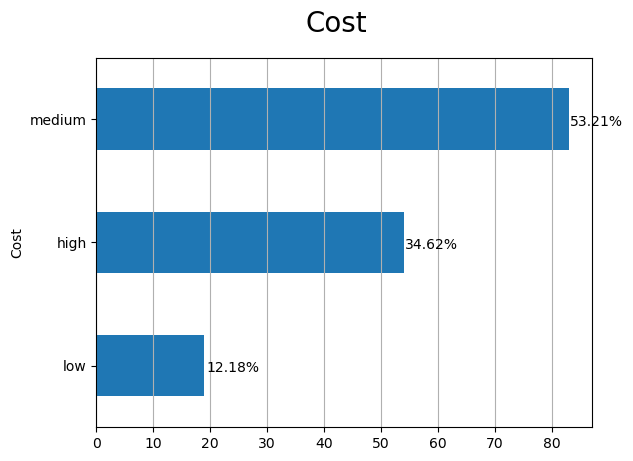

In [7]:
x = "Cost"
ax = dtf[x].value_counts().sort_values().plot(kind="barh")
totals = []
for i in ax.patches:
    totals.append(i.get_width())
total = sum(totals)
for i in ax.patches:
     ax.text(i.get_width()+.3, i.get_y()+.20,
     str(round((i.get_width()/total)*100, 2))+'%',
     fontsize=10, color='black')
ax.grid(axis="x")
plt.suptitle(x, fontsize=20)
plt.show()


Beberapa catatan interpretasi grafik:
* Biaya medium mendominasi: 53.21% toko memiliki biaya operasi tahunan pada kategori medium.
* Biaya high signifikan: 34.62% toko termasuk kategori high.
* Biaya low paling sedikit: hanya 12.18% toko yang memiliki biaya operasi low
* Mayoritas toko berada pada biaya medium dan high, yang menunjukkan bahwa biaya operasional Starbucks secara umum tidak murah untuk sebagian besar outlet.
* Persentase toko dengan biaya rendah relatif kecil. Hal ini bisa mengindikasikan bahwa hanya sebagian kecil toko yang efisien secara biaya.
* Jika tujuan bisnis adalah merasionalisasi atau menutup toko yang paling membebani biaya, fokus bisa diarahkan ke toko-toko pada kategori high, terutama jika tidak diimbangi dengan kinerja penjualan yang baik.



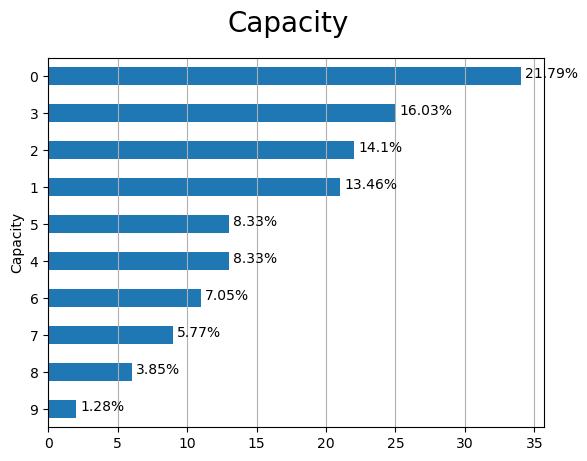

In [8]:
x = "Capacity"
ax = dtf[x].value_counts().sort_values().plot(kind="barh")
totals = []
for i in ax.patches:
    totals.append(i.get_width())
total = sum(totals)
for i in ax.patches:
     ax.text(i.get_width()+.3, i.get_y()+.20,
     str(round((i.get_width()/total)*100, 2))+'%',
     fontsize=10, color='black')
ax.grid(axis="x")
plt.suptitle(x, fontsize=20)
plt.show()


Beberapa catatan interpretasi grafik:
* Kapasitas 0 mendominasi dengan 21.79% dari total toko, artinya paling banyak toko mencapai batas kapasitas staffnya yaitu 0.
* Kapasitas 1, 2, dan 3 cukup berimbang di kisaran 13–16%, menunjukkan sekelompok besar toko memiliki sedikit ruang untuk tambahan staff.
* Kapasitas di atas 4 makin jarang ditemukan. toko dengan kapasitas 6–9 hanya sedikit, misalnya kapasitas 9 hanya 1,28% toko.
* Mayoritas toko memiliki kapasitas sisa rendah–sedang (0–3), menandakan bahwa toko-toko sudah mendekati batas optimal staf atau hanya bisa menambah sedikit staf lagi.
* Toko dengan kapasitas 0 (14,1%) berarti sudah penuh secara staf — ini bisa jadi sinyal bahwa toko sudah berjalan dengan maksimal atau malah overstaffing jika kinerja toko kurang baik.
* Sebaliknya, toko dengan kapasitas besar (6–9) cukup jarang, sehingga jika ada, perlu dievaluasi apakah kekurangan staf atau memang memiliki desain dan potensi besar yang belum dioptimalkan.
* Data ini penting untuk mendukung keputusan rasionalisasi: toko dengan kapasitas penuh dan performa rendah bisa dipertimbangkan untuk diubah strategi atau ditutup, sedangkan toko dengan kapasitas besar namun berkinerja baik bisa menjadi prioritas pengembangan.

Mari kita visualisasikan potongan-potongan informasi itu di peta. Pertama-tama, Kita perlu mendapatkan koordinat area geografis untuk memulai peta. Kita akan melakukannya dengan geopy:

In [9]:
city = "Las Vegas"
## get location
locator = geopy.geocoders.Nominatim(user_agent="MyCoder")
location = locator.geocode(city)
print(location)
## keep latitude and longitude only
location = [location.latitude, location.longitude]
print("[lat, long]:", location)

Las Vegas, Clark County, Nevada, United States
[lat, long]: [36.1674263, -115.1484131]


Kita akan membuat peta dengan folium, package yang sangat nyaman yang memungkinkan kita untuk memplot peta interaktif tanpa perlu memuat shapefile. Setiap toko harus diidentifikasi dengan titik dengan ukuran proporsional dengan staf saat ini dan warna berdasarkan biayanya. Kita juga akan menambahkan sepotong kecil kode HTML ke peta default untuk menampilkan legenda.

In [10]:
x, y = "Latitude", "Longitude"
color = "Cost"
size = "Staff"
popup = "Street Address"
data = dtf.copy()

## create color column
lst_colors=["red","green","orange"]
lst_elements = sorted(list(dtf[color].unique()))
data["color"] = data[color].apply(lambda x:
                lst_colors[lst_elements.index(x)])
## create size column (scaled)
scaler = preprocessing.MinMaxScaler(feature_range=(3,15))
data["size"] = scaler.fit_transform(
               data[size].values.reshape(-1,1)).reshape(-1)

## initialize the map with the starting location
map_ = folium.Map(location=location, tiles="cartodbpositron",
                  zoom_start=11)
## add points
data.apply(lambda row: folium.CircleMarker(
           location=[row[x],row[y]], popup=row[popup],
           color=row["color"], fill=True,
           radius=row["size"]).add_to(map_), axis=1)
## add html legend
legend_html = """<div style="position:fixed; bottom:10px; left:10px; border:2px solid black; z-index:9999; font-size:14px;">&nbsp;<b>"""+color+""":</b><br>"""
for i in lst_elements:
     legend_html = legend_html+"""&nbsp;<i class="fa fa-circle
     fa-1x" style="color:"""+lst_colors[lst_elements.index(i)]+"""">
     </i>&nbsp;"""+str(i)+"""<br>"""
legend_html = legend_html+"""</div>"""
map_.get_root().html.add_child(folium.Element(legend_html))

## plot the map
map_

Tujuan kita adalah untuk menutup sebanyak mungkin toko berbiaya tinggi (titik merah) dengan memindahkan staf mereka ke toko berbiaya rendah (titik hijau) dengan kapasitas yang terletak di lingkungan yang sama. Akibatnya, kita akan memaksimalkan keuntungan (dengan menutup toko berbiaya tinggi) dan efisiensi (dengan memiliki toko berbiaya rendah yang bekerja dengan kapasitas penuh).

# Model Building : Clustering and Evaluation

Di sini, untuk menentukan k yang tepat, Kita akan menggunakan Elbow Method: memplot varians sebagai fungsi dari jumlah cluster dan memilih k yang meratakan kurva.

C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Wi

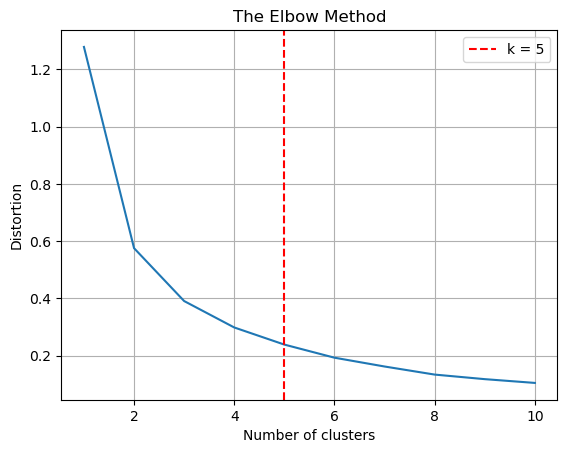

In [11]:
X = dtf[["Latitude","Longitude"]]
max_k = 10
## iterations
distortions = []
for i in range(1, max_k+1):
    if len(X) >= i:
       model = cluster.KMeans(n_clusters=i, init='k-means++', max_iter=3000, n_init=10, random_state=0)
       model.fit(X)
       distortions.append(model.inertia_)
## best k: the lowest derivative
k = [i*100 for i in np.diff(distortions,2)].index(min([i*100 for i
     in np.diff(distortions,2)]))
## plot
fig, ax = plt.subplots()
ax.plot(range(1, len(distortions)+1), distortions)
ax.axvline(k, ls='--', color="red", label="k = "+str(k))
ax.set(title='The Elbow Method', xlabel='Number of clusters',
       ylabel="Distortion")
ax.legend()
ax.grid(True)
plt.show()

Kita dapat mencoba dengan k = 5 sehingga algoritma K-Means akan menemukan 5 centroid teoritis. Selain itu, Kita juga akan mengidentifikasi centroid sebenarnya (pengamatan terdekat dengan pusat cluster).

In [13]:
k = 5
model = cluster.KMeans(n_clusters=k, init='k-means++')
X = dtf[["Latitude","Longitude"]]

## clustering
dtf_X = X.copy()
dtf_X["cluster"] = model.fit_predict(X)

## find real centroids
closest, distances = scipy.cluster.vq.vq(model.cluster_centers_, dtf_X.drop("cluster", axis=1).values)
dtf_X["centroids"] = 0
for i in closest:
    dtf_X.loc[dtf_X.index[i], "centroids"] = 1 

## add clustering info to the original dataset
dtf[["cluster","centroids"]] = dtf_X[["cluster","centroids"]]
dtf.sample(5)

C:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


,id,City,Street Address,Longitude,Latitude,Potential,Staff,Capacity,Cost,cluster,centroids
88,88,Las Vegas,4055 South Durango Drive,-115.28,36.12,6,1,5,high,1,0
137,137,Las Vegas,7350 S Rainbow Blvd,-115.24,36.05,8,3,5,low,4,0
135,135,Las Vegas,"2412 E. Desert Inn Road, #100",-115.12,36.13,9,1,8,medium,3,0
79,79,Las Vegas,5757 Wayne Newton Blvd,-115.15,36.08,10,9,1,medium,0,0
33,33,Las Vegas,"5566 Boulder Highway, #2C",-115.05,36.10,9,9,0,medium,3,0


Kita menambahkan dua kolom ke dataset: "cluster" yang menunjukkan cluster apa yang menjadi milik observasi, dan "centroids" yaitu 1 jika pengamatan juga merupakan centroid (paling dekat dengan pusat) dan 0 sebaliknya. Mari kita rencanakan:

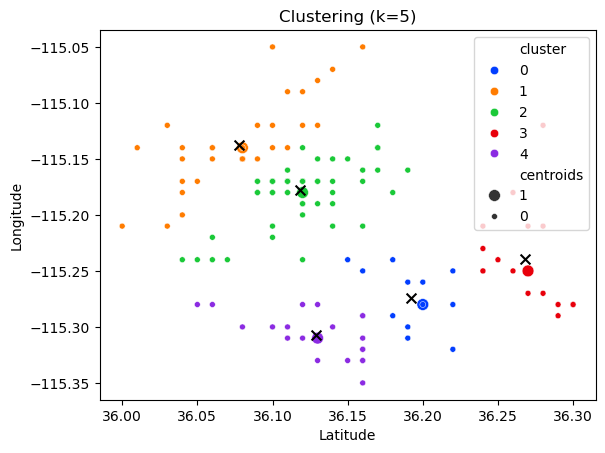

In [15]:
## plot
fig, ax = plt.subplots()
sns.scatterplot(x="Latitude", y="Longitude", data=dtf,
                palette=sns.color_palette("bright",k),
                hue='cluster', size="centroids", size_order=[1,0],
                legend="brief", ax=ax).set_title('Clustering (k='+str(k)+')')
th_centroids = model.cluster_centers_
ax.scatter(th_centroids[:,0], th_centroids[:,1], s=50, c='black',
           marker="x")

Terlepas dari algoritma yang Anda gunakan untuk mengelompokkan data, sekarang Anda memiliki kumpulan data dengan dua kolom lagi (“cluster”, “centroids”). Kita dapat menggunakannya untuk memvisualisasikan cluster pada peta, dan kali ini kita akan menampilkan centroid juga menggunakan marker.

In [16]:
x, y = "Latitude", "Longitude"
color = "cluster"
size = "Staff"
popup = "Street Address"
marker = "centroids"
data = dtf.copy()
## create color column
lst_elements = sorted(list(dtf[color].unique()))
lst_colors = ['#%06X' % np.random.randint(0, 0xFFFFFF) for i in
              range(len(lst_elements))]
data["color"] = data[color].apply(lambda x:
                lst_colors[lst_elements.index(x)])
## create size column (scaled)
scaler = preprocessing.MinMaxScaler(feature_range=(3,15))
data["size"] = scaler.fit_transform(
               data[size].values.reshape(-1,1)).reshape(-1)
## initialize the map with the starting location
map_ = folium.Map(location=location, tiles="cartodbpositron",
                  zoom_start=11)
## add points
data.apply(lambda row: folium.CircleMarker(
           location=[row[x],row[y]], popup=row[popup],
           color=row["color"], fill=True,
           radius=row["size"]).add_to(map_), axis=1)
## add html legend
legend_html = """<div style="position:fixed; bottom:10px; left:10px; border:2px solid black; z-index:9999; font-size:14px;">&nbsp;<b>"""+color+""":</b><br>"""
for i in lst_elements:
     legend_html = legend_html+"""&nbsp;<i class="fa fa-circle
     fa-1x" style="color:"""+lst_colors[lst_elements.index(i)]+"""">
     </i>&nbsp;"""+str(i)+"""<br>"""
legend_html = legend_html+"""</div>"""
map_.get_root().html.add_child(folium.Element(legend_html))
## add centroids marker
lst_elements = sorted(list(dtf[marker].unique()))
data[data[marker]==1].apply(lambda row:
           folium.Marker(location=[row[x],row[y]],
           popup=row[marker], draggable=False,
           icon=folium.Icon(color="black")).add_to(map_), axis=1)
## plot the map
map_

Sekarang kita memiliki cluster, kita dapat memulai rasionalisasi toko di dalam masing-masing cluster.

# Store Rationalization

Karena fokus utama artikel ini adalah mengelompokkan data geospasial, Kita akan membuat bagian ini tetap sederhana. Di dalam setiap cluster, Kita akan memilih target potensial (toko berbiaya tinggi) dan hub (toko berbiaya rendah), dan merelokasi staf target di hub sampai yang terakhir mencapai kapasitas penuh. Ketika seluruh staf target dipindahkan, toko bisa ditutup.

In [17]:
dtf_new = pd.DataFrame()
for c in sorted(dtf["cluster"].unique()):
    dtf_cluster = dtf[dtf["cluster"]==c]
    
    ## hubs and targets
    lst_hubs = dtf_cluster[dtf_cluster["Cost"]=="low"
               ].sort_values("Capacity").to_dict("records")
    lst_targets = dtf_cluster[dtf_cluster["Cost"]=="high"
               ].sort_values("Staff").to_dict("records")
    ## move targets
    ## Algoritma Pemindahan (logika greedy)
    for target in lst_targets: ## untuk setiap toko biaya tinggi
         for hub in lst_hubs: ## coba pindahkan ke setiap toko biaya rendah
             ### if hub has space
             if hub["Capacity"] > 0: ## jika hub masih punya kapasitas
                residuals = hub["Capacity"] - target["Staff"]
                #### Kasus 1: Kapasitas cukup menampung semua staf dari target
                if residuals >= 0:
                   hub["Staff"] += target["Staff"]  # pindahkan semua staf
                   hub["Capacity"] = hub["Potential"] - hub["Staff"] # hitung ulang
                   target["Capacity"] = target["Potential"] 
                   target["Staff"] = 0 # target kosong
                   break
                #### Kasus 2: Kapasitas tidak cukup, pindahkan sebagian
                else:
                   hub["Capacity"] = 0
                   hub["Staff"] = hub["Potential"] # kapasitas penuh
                   target["Staff"] = -residuals # sisa staf tetap di target
                   target["Capacity"] = target["Potential"] - target["Staff"]
    dtf_new = pd.concat([dtf_new, pd.DataFrame(lst_hubs), pd.DataFrame(lst_targets)], ignore_index=True)
dtf_new = pd.concat([dtf_new, dtf[dtf["Cost"]=="medium"]], 
                    ignore_index=True).sort_values(["cluster", "Staff"]).reset_index(drop=True)
dtf_new.head()

,id,City,Street Address,Longitude,Latitude,Potential,Staff,Capacity,Cost,cluster,centroids
0,3,Las Vegas,8350 W Cheyenne Ave,-115.28,36.22,3,0,3,high,0,0
1,62,Las Vegas,"7541 West Lake Mead Boulevard, Suite 300, Fash...",-115.26,36.20,5,0,5,high,0,0
2,149,Las Vegas,221 N Rampart Blvd,-115.29,36.18,6,1,5,medium,0,0
3,119,Las Vegas,"1772 S. Rainbow Blvd, #110",-115.24,36.15,8,2,6,high,0,0
4,111,Las Vegas,1650 N Buffalo Dr,-115.26,36.19,8,2,6,medium,0,0


Ini adalah algoritma yang sangat sederhana yang dapat ditingkatkan dalam beberapa cara: misalnya, dengan memasukkan toko-toko berbiaya menengah ke dalam persamaan dan meniru prosesnya ketika toko-toko berbiaya rendah semuanya penuh.

Mari kita lihat berapa banyak toko mahal yang kita tutup dengan proses dasar ini:

In [18]:
dtf_new["closed"] = dtf_new["Staff"].apply(lambda x: 1
                                           if x==0 else 0)
print("closed:", dtf_new["closed"].sum())
print(dtf_new.closed.value_counts())

closed: 21
closed
0    135
1     21
Name: count, dtype: int64


In [19]:
x, y = "Latitude", "Longitude"
color = "cluster"
size = "Staff"
popup = "Street Address"
marker = "centroids"
data = dtf_new.copy()
## create color column
lst_elements = sorted(list(dtf[color].unique()))
lst_colors = ['#%06X' % np.random.randint(0, 0xFFFFFF) for i in
              range(len(lst_elements))]
data["color"] = data[color].apply(lambda x:
                lst_colors[lst_elements.index(x)])
## create size column (scaled)
scaler = preprocessing.MinMaxScaler(feature_range=(3,15))
data["size"] = scaler.fit_transform(
               data[size].values.reshape(-1,1)).reshape(-1)
## initialize the map with the starting location
map_ = folium.Map(location=location, tiles="cartodbpositron",
                  zoom_start=11)
## add points
data.apply(lambda row: folium.CircleMarker(
           location=[row[x],row[y]], popup=row[popup],
           color=row["color"], fill=True,
           radius=row["size"]).add_to(map_), axis=1)
## add html legend
legend_html = """<div style="position:fixed; bottom:10px; left:10px; border:2px solid black; z-index:9999; font-size:14px;">&nbsp;<b>"""+color+""":</b><br>"""
for i in lst_elements:
     legend_html = legend_html+"""&nbsp;<i class="fa fa-circle
     fa-1x" style="color:"""+lst_colors[lst_elements.index(i)]+"""">
     </i>&nbsp;"""+str(i)+"""<br>"""
legend_html = legend_html+"""</div>"""
map_.get_root().html.add_child(folium.Element(legend_html))
## add centroids marker
lst_elements = sorted(list(dtf[marker].unique()))
data[data[marker]==1].apply(lambda row:
           folium.Marker(location=[row[x],row[y]],
           popup=row[marker], draggable=False,
           icon=folium.Icon(color="black")).add_to(map_), axis=1)
## plot the map
map_